# Model Build Comparisons

## microprocessor settings

In [2]:
# Run development environment checks for dependencies and GPU compute
import tensorflow as tf

print("TensorFlow version:", tf.__version__)
print("Is built with CUDA:", tf.test.is_built_with_cuda())
print("GPUs detected:", tf.config.list_physical_devices('GPU'))

2025-07-20 12:01:49.580608: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1753012909.603557    6788 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1753012909.610921    6788 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1753012909.629081    6788 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1753012909.629110    6788 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1753012909.629115    6788 computation_placer.cc:177] computation placer alr

TensorFlow version: 2.19.0
Is built with CUDA: True
GPUs detected: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [ ]:
# If GPU compute fails run on CPU fallbacks
import os

# CPU fallback
os.environ["CUDA_VISIBLE_DEVICES"] = "-1"
os.environ["XLA_PYTHON_CLIENT_PREALLOCATE"] = "false"
os.environ["TF_FORCE_GPU_ALLOW_GROWTH"] = "false"

# Optional: Limit threads to prevent CPU overload
os.environ["OMP_NUM_THREADS"] = "2"
os.environ["TF_NUM_INTRAOP_THREADS"] = "2"
os.environ["TF_NUM_INTEROP_THREADS"] = "2"

print("Environment variables set: CUDA disabled, using CPU fallback")

In [3]:
# If running cloud dev. Fallbacks on pip may be needed. 
# Run env checks
import os

print(os.getcwd())

/lambda/nfs/rc-dds/notebooks


In [ ]:
#!pip install transformers

In [ ]:
#!pip install tf-keras

In [ ]:
#!pip install datasets

In [ ]:
#!pip uninstall pillow -y

In [ ]:
#!pip install --no-cache-dir pillow --upgrade

In [ ]:
#!pip install xgboost

In [ ]:
#!pip install pylatex

In [1]:
#!rm -rf ~/.cache/huggingface

## load/run models

In [4]:
import os
import xgboost as xgb
from tensorflow.keras.models import load_model
from transformers import TFGPT2ForSequenceClassification, GPT2TokenizerFast

# Set file paths
os.chdir("../")  

# Load pretrained models
model1 = load_model("models/basemodel.keras")     
model2 = TFGPT2ForSequenceClassification.from_pretrained("models/model2.keras", from_pt=False)
tokenizer = GPT2TokenizerFast.from_pretrained("models/model2.keras")
model3 = load_model("models/model3.keras") 
model4 = xgb.Booster()
model4.load_model("models/xgb_model.json")

# Set model names         
models = [model1, model2, model3, model4]   
model_names = ["EfficientNetB0 (base model)", "GPT2", "Word2Vec", "XGBoost"]

/home/ubuntu/.local/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
I0000 00:00:1753012923.595369    6788 gpu_device.cc:2019] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 22808 MB memory:  -> device: 0, name: Quadro RTX 6000, pci bus id: 0000:07:00.0, compute capability: 7.5
/usr/lib/python3/dist-packages/keras/src/saving/saving_lib.py:802: UserWarning: Skipping variable loading for optimizer 'rmsprop', because it has 8 variables whereas the saved optimizer has 14 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))
TensorFlow and JAX classes are deprecated and will be removed in Transformers v5. We recommend migrating to PyTorch classes or pinning your version of Transformers.
All model checkpoint layers were used when initializing TFGPT2ForSequenceClassification

In [5]:
# Load test sets samples
import random
import numpy as np
from datasets import load_dataset

# Load in data
USE_PERCENTAGE = 1.00

# Load dataset
dataset = load_dataset("deepcopy/MathWriting-human")
total_val_samples = int(USE_PERCENTAGE * len(dataset["val"]))
val_data = dataset["val"].select(range(total_val_samples))

latex_pool = dataset["train"]["latex"]

# Add binary_label and latex_used to val_data
def add_binary_label(example):
    if random.random() > 0.5:
        example["binary_label"] = 1
        example["latex_used"] = example["latex"]
    else:
        wrong_latex = random.choice(latex_pool)
        while wrong_latex == example["latex"]:
            wrong_latex = random.choice(latex_pool)
        example["binary_label"] = 0
        example["latex_used"] = wrong_latex
    return example

# Map test set labels
val_data = val_data.map(add_binary_label)
y_test = np.array(val_data["binary_label"]).astype(int)
print(f"Loaded {len(y_test)} labeled test samples.")

Map: 100%|██████████| 15674/15674 [00:38<00:00, 404.48 examples/s]


Loaded 15674 labeled test samples.


In [6]:
# Needed to convert HF to TF dataset
"""
HF stack has a different framework from TF - transformers, datasets etc
"""
import tensorflow as tf

def hf_to_tf_dataset(hf_dataset, batch_size=16):
    def gen():
        for ex in hf_dataset:
            img_array = ex["image"]["array"] if isinstance(ex["image"], dict) and "array" in ex["image"] else ex["image"]
            img = tf.image.resize(tf.image.convert_image_dtype(img_array, tf.float32), (224, 224))
            label = ex["binary_label"]
            yield img, label

    output_signature = (
        tf.TensorSpec(shape=(224, 224, 3), dtype=tf.float32),
        tf.TensorSpec(shape=(), dtype=tf.int32)
    )

    tf_dataset = tf.data.Dataset.from_generator(gen, output_signature=output_signature)
    tf_dataset = tf_dataset.batch(batch_size).prefetch(tf.data.AUTOTUNE)
    return tf_dataset

X_test_tf = hf_to_tf_dataset(val_data)

In [ ]:
# Pull test set data from cached memory if runtime is slow
import tensorflow as tf

# Preprocess from cache image-label pairs. Build tf.data.Dataset
cached_imgs = []
cached_labels = []

for ex in val_data:
    img_array = ex["image"]["array"] if isinstance(ex["image"], dict) and "array" in ex["image"] else ex["image"]
    img = tf.image.resize(tf.image.convert_image_dtype(img_array, tf.float32), (224, 224))
    label = ex["binary_label"]
    cached_imgs.append(img)
    cached_labels.append(label)

# Convert to tf.data.Dataset
X_test_tf = tf.data.Dataset.from_tensor_slices((cached_imgs, cached_labels))
X_test_tf = X_test_tf.batch(16).prefetch(tf.data.AUTOTUNE)

print("Cached and batched test set ready.")

## model predictions

In [9]:
# Model 1 - EfficientNetB0 (base model)

# Warmup pass (optional but recommended)
for warmup_batch in X_test_tf.take(3941):
    warmup_images, _ = warmup_batch
    _ = model1.predict(warmup_images, verbose=0)
    break

# Full prediction
probs_dict = {}
y_probs = model1.predict(X_test_tf, verbose=1).ravel()
probs_dict["EfficientNetB0 (base model)"] = y_probs

980/980 ━━━━━━━━━━━━━━━━━━━━ 63s 64ms/step


In [10]:
# Model 2 - GPT2
import tensorflow as tf
import numpy as np
from tqdm import tqdm


latex_inputs = [str(item) for item in val_data["latex_used"]]
batch_size = 16  # Adjust for memory limits
y_probs_model2 = []

for i in tqdm(range(0, len(latex_inputs), batch_size)):
    batch_texts = latex_inputs[i:i+batch_size]
    inputs = tokenizer(
        batch_texts,
        padding=True,
        truncation=True,
        max_length=64,
        return_tensors="tf"
    )

    outputs = model2(inputs)
    if outputs.logits.shape[1] == 1:
        probs = tf.math.sigmoid(outputs.logits).numpy().ravel()
    else:
        probs = tf.nn.softmax(outputs.logits, axis=1)[:, 1].numpy()

    y_probs_model2.extend(probs)

# Generate predictions
probs_dict["GPT2"] = np.array(y_probs_model2)

100%|██████████| 980/980 [02:31<00:00,  6.48it/s]


In [11]:
# Model 3 - Word2Vec + Model 4 - XGBoost
from sklearn.feature_extraction.text import TfidfVectorizer

vectorizer = TfidfVectorizer(max_features=1000)
X_latex = vectorizer.fit_transform(val_data["latex_used"])

# Model 3 - Word2Vec
y_probs_m3 = model3.predict(X_latex.toarray()).ravel()
probs_dict["Word2Vec"] = y_probs_m3

# Model 4 - XGBoost
xgb_dmatrix = xgb.DMatrix(X_latex)
y_probs_xgb = model4.predict(xgb_dmatrix)
probs_dict["XGBoost"] = y_probs_xgb

490/490 ━━━━━━━━━━━━━━━━━━━━ 16s 31ms/step


In [12]:
y_test = np.array(val_data["binary_label"]).astype(int)

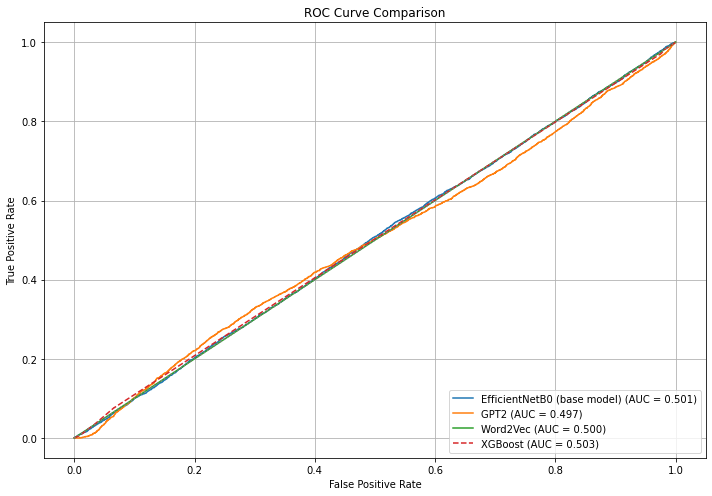

In [13]:
# Plot ROC AUC curves for all models
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc
import numpy as np

plt.figure(figsize=(10, 7))

# y_test must already be defined from val_data
for name, y_probs in probs_dict.items():
    fpr, tpr, _ = roc_curve(y_test, y_probs)
    roc_auc = auc(fpr, tpr)
    linestyle = '--' if name == "XGBoost" else '-'
    plt.plot(fpr, tpr, linestyle=linestyle, label=f"{name} (AUC = {roc_auc:.3f})")

plt.plot([0, 1], [0, 1], linestyle=':', color='gray')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve Comparison")
plt.legend(loc="lower right")
plt.grid(True)
plt.tight_layout()
plt.show()

## Model Debugging
I ran into a lot of bottlenecks. I/O in model building requires input and output shapes to match exactly

In [15]:
# Inspect model input shapes to determine compatibility
models_to_check = [("EfficientNetB0 (basel model)", model1), ("Word2Vec", model3)]

for name, model in models_to_check:
    try:
        model.build()
        print(f"{name} input shape: {model.input_shape}")
    except Exception as e:
        print(f"Could not determine input shape for {name}: {e}")

Could not determine input shape for EfficientNetB0 (basel model): Functional.build() missing 1 required positional argument: 'input_shape'
Word2Vec input shape: (None, 64)


In [ ]:
# GPT2
import os

model2_dir = "models/model2.keras"

print(f"Contents of {model2_dir}:")
for root, dirs, files in os.walk(model2_dir):
    level = root.replace(model2_dir, '').count(os.sep)
    indent = ' ' * 2 * level
    print(f"{indent}{os.path.basename(root)}/")
    subindent = ' ' * 2 * (level + 1)
    for f in files:
        print(f"{subindent}{f}")

In [ ]:
# GPT2
import h5py

weight_path = "models/model2.keras/tf_model.h5"
with h5py.File(weight_path, "r") as f:
    print("Top-level keys (layers):", list(f.keys()))
    for layer_name in f.keys():
        print(f"\nLayer: {layer_name}")
        layer_group = f[layer_name]
        for weight_name in layer_group.keys():
            weight = layer_group[weight_name]
            if isinstance(weight, h5py.Dataset):
                print(f"  {weight_name}: shape {weight.shape}")
            else:
                print(f"  {weight_name}: <not a dataset>")

## generate sample inference outputs

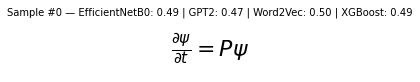

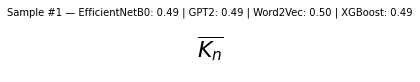

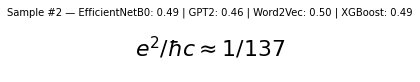

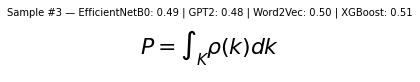

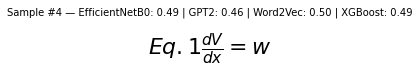

In [18]:
import matplotlib.pyplot as plt
from IPython.display import display

# Generate some sample outputs
latex_inputs = val_data["latex_used"][:5]  
model_outputs = {
    "EfficientNetB0": probs_dict["EfficientNetB0 (base model)"][:5],
    "GPT2": probs_dict["GPT2"][:5],
    "Word2Vec": probs_dict["Word2Vec"][:5],
    "XGBoost": probs_dict["XGBoost"][:5]
}

for i, latex_str in enumerate(latex_inputs):
    latex_render = f"${latex_str}$"
    fig, ax = plt.subplots(figsize=(6, 1))
    ax.axis('off')
    ax.text(0.5, 0.5, latex_render, fontsize=22, ha='center', va='center')

    title_str = " | ".join([
        f"{name}: {model_outputs[name][i]:.2f}" for name in model_outputs
    ])
    plt.title(f"Sample #{i} — {title_str}", fontsize=10)

    display(fig)
    plt.close(fig)

## Conclusion: 

XGBoost generalizes suprisingly well from these builds though the features were surprising. EfficientNetB0 - base model provided a concrete baseline to build from. I was expecting GPT2 to have more pronounced results. For large language models, model accuracy for the field of mathematics requires rigorous precision, accuracy, and metrics. For NLP and computer vision research in mathematical problem solving this can be challenging. The field of mathematics is a very granular and highly technical space. To my knowledge it doesn't seem there is much research in structured tabular data for NLP or maybe even computer vision.

Future research and work is needed. Because math is a highly rigorous field of study and a cornerstone in society, it makes sense why it has not caught up yet to natural text to text NLP and computer vision respectively. These were time constrained research and builds and I would have liked to perfect the craftmanship on these builds. At the time of this writing the version-tab project is suboptimal due to time constraints as well. It requires a second look. Another requirement in this space I propose should be robust cybersecurity tools in the AI space. This project may be in the few that scans its GitHub repository for security vulnerabilities. This should be common practice in the field of AI. Overall, the research shows much promise for further research and development in computer vision and other domains in AI.